비 분산훈련
```
data : MNIST
CNN
1. 데이터셋
  데이터 전처리(이미지정규화, 텐서)
2. 데이터로더
3. cnn 아키텍처 - 모델
4. 학습에필요한 설정
  손실함수, 옵티마이져, 에포크수, learning_rate
5. 학습루프
6. 평가
7. 추론(예측)
```

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

In [ ]:
from torchvision.datasets import MNIST
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 데이터 전처리
transforms = Compose([
 ToTensor(),
 Normalize(mean=(0.5,),std=(0.25,))
])
# mnist 데이터셋
train_dataset = MNIST(root='./',train=True,download=True,transform=transforms)
test_dataset =  MNIST(root='./',train=False,download=True,transform=transforms)
# 데이터 로더
train_loader = DataLoader(train_dataset,batch_size = 64 , shuffle=True)
test_loader = DataLoader(test_dataset,batch_size = 64 )
data,label = next(iter(train_loader))
data.shape

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.76MB/s]


torch.Size([64, 1, 28, 28])

In [ ]:
# cnn 모델  c-p-c-p-d-fc-fc
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1)  # 32, 14, 14
    self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1) # 64, 7, 7
    self.pooling = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(0.25)
    self.fc1 = nn.Linear( 64*7*7 , 128)
    self.fc2 = nn.Linear(128 , 10)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.pooling(self.relu(self.conv1(x)))
    x = self.pooling(self.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x,start_dim=1)  #(B , 64, 7, 7) - >(B , 64x7x7)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)  # softmax는 적용 안함. why? 손실함수인 크로스엔트로피 내부에 softmax 기능이 내장 적용
    return x

In [ ]:
from tqdm import tqdm
def train(model,device,train_loader,optimizer,epochs):
  loss_fn = nn.CrossEntropyLoss()
  model.to(device)
  for epoch in range(epochs):
    iterator = tqdm(train_loader)
    for data, label in iterator:
      data,label = data.to(device), label.to(device)
      output = model(data)
      loss =loss_fn(output, label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      iterator.set_description(f"epoch:{epoch+1}")
      iterator.set_postfix(loss=loss.item())
model = MnistModel()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
train(model,device,train_loader,optimizer,10)

epoch:10: 100%|██████████| 938/938 [00:17<00:00, 53.76it/s, loss=0.00702]


AttributeError: 'MnistModel' object has no attribute 'save_state_dict'

In [ ]:
torch.save(model.state_dict(),'mnist_model.pth')

모델 로드

In [ ]:
loaded_model = MnistModel()
loaded_model.load_state_dict(torch.load('mnist_model.pth',map_location=device))

<All keys matched successfully>

모델 테스트

In [ ]:
def test(model, device, test_loader):
  loss_fn = nn.CrossEntropyLoss()
  model = model.to(device)
  model.eval()
  total_loss = 0.0
  total_correct = 0
  with torch.no_grad():
    for data,label in test_loader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      total_loss +=  loss_fn(output, label)
      predict = output.argmax(1)
      total_correct += predict.eq(label).sum().item()
  total_loss /= len(test_loader.dataset)
  print(f'total_loss : {total_loss} accuracy : {total_correct / len(test_loader.dataset)}')

test(loaded_model,device,test_loader)

total_loss : 0.00045137174311093986 accuracy : 0.9897


분산처리
```
단일 gpu에 대해서
DistributedDataParallel (DDP)
  pytorch의 분산 학습을 위한 모듈
  여러 gpu에서 모델을 병렬로 학습 할 수 있게
  각 gpu는 모델의 복사본을 가지고 데이터의 일부를 처리
  데이터는 자동으로 분배
  그레이디언트는 자동으로 동기화

작동방식
  초기화
  데이터 분배
  학습을 기존 과정과 동일(순전파, 역전파, 업데이트)
```

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, DistributedSampler
from torchvision import transforms
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import os
import time

모델 검증
```
모델의 일반화 성능을 평가하기위한 방법
1. train/validation/tets  split
  train : 모델 학습
  validation : 학습중에 모델 검증. 하이퍼파라메터 튜닝 과적합 감지
  test : 학습이 모두 끝난다음 최종 평가
2. k-fold 교차 검증(Cross Validation)
  딥러닝에서는 사용을 자제(시간이 오래 걸려)
  k 폴드로나눠서 k-1개로 학습, 나머지 1개 검증반복 ,평균
  모델의 일관성과 과적합여부를 점검
3. Ealy Stopping
  검증 데이터의 손실이 일정 epoch 이상 개선되지 않으면 중단
  과적합 방지에 효과
4. 평가 지표
  분류 : Accuracy, Precison, Recall ,F1-Score ,ROC-AUC
  회귀 : MSE, MAE, RMSE, R^2
```
혼동행렬(Confution Matrix)

\begin{array}{c|c|c}
 & \textbf{실제 Positive (1)} & \textbf{실제 Negative (0)} \\
\hline
\textbf{예측 Positive (1)} & TP & FP \\
\textbf{예측 Negative (0)} & FN & TN \\
\end{array}   
```

1. Accuracy(정확도)
```
데이터가 균형잡혀 있을때
```
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

2. 정밀도 Precision
```
  positive 예측중 정답 비율, FP를 줄여야할때(ex 스펨필터)
```
$$
\text{Precision} = \frac{TP}{TP + FP}
$$


3. Recall(재현율, 민감도)
```
실제 Positive 중에서 맞춘비율, FN을 줄여야할때,ex 암진단
```

$$
\text{Recall} = \frac{TP}{TP + FN}
$$


4. F1 스코어  :  Precision + Recall  조화평균

$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2TP}{2TP + FP + FN}
$$


ROC 커브
```
  TPR(Recall) : ROC에서 y축 모델의 민감도
  FPR  : ROC에서 x축 거짓 Positive의 비율
```
ROC-ACU
```
  ROC 곡선 아래 면적
  auc = 1.0 - >완벽한분류
        0.5 - >랜덤 추측 수준
  poistive vs nagative의 구분능력 , 전체 이진분류의 성능평가  
```

$$
\text{TPR} = \frac{TP}{TP + FN}
$$

$$
\text{FPR} = \frac{FP}{FP + TN}
$$


다중모델은  사이킷런의 classification_report를 이용하면 각 라벨별 confusion metirx을 제공

In [ ]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, roc_curve, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

xgb = XGBClassifier(randam_state=42)
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)
proba = xgb.predict_proba(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:50:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randam_state" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# 결정계수로 확인  : 모델의 변동성을 나타내고. 1에 가까울소록 좋은 성능을 나타냄
# 회귀모델은 오차의 값으로 모델의 성능을 평가하기에 한계가 있음
from sklearn.datasets import fetch_california_housing

In [ ]:
california = fetch_california_housing()
X = california.data
y = california.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 여러모델을 정의
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
models = {
    'Linear Regression' : LinearRegression(),
    'Ridge Regression' : Ridge(),
    'Lasso Regression' : Lasso(),
    'Random Fores' : RandomForestRegressor(),
    'xgboost' : XGBRegressor(),
    'light gbm' : LGBMRegressor()
}
# 단순한 훈련 테스트
for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f'{name} : mse = {mse} r2score = {r2}')

Linear Regression : mse = 0.5558915986952422 r2score = 0.5757877060324524
Ridge Regression : mse = 0.5558034669932196 r2score = 0.5758549611440138
Lasso Regression : mse = 0.9380337514945428 r2score = 0.2841671821008396
Random Fores : mse = 0.2535805699780551 r2score = 0.8064874598780122
xgboost : mse = 0.2225899267544737 r2score = 0.8301370561019205
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


light gbm : mse = 0.21484820209255617 r2score = 0.8360449251645318


In [ ]:
# 결정계수로 확인  : 모델의 변동성을 나타내고. 1에 가까울소록 좋은 성능을 나타냄
# 회귀모델은 오차의 값으로 모델의 성능을 평가하기에 한계가 있음
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
california = fetch_california_housing()
X = california.data
y = california.target
from sklearn.preprocessing import RobustScaler
X = RobustScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 여러모델을 정의
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
models = {
    'Linear Regression' : LinearRegression(),
    'Ridge Regression' : Ridge(max_iter = 1000),
    'Lasso Regression' : Lasso(),
    'Random Fores' : RandomForestRegressor(),
    'xgboost' : XGBRegressor(),
    'light gbm' : LGBMRegressor(force_col_wise=True, ensure_all_finite=True)
}
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
# 단순히 훈련 테스트
for name, model in models.items():
  if name in ('Linear Regression','Ridge Regression','Lasso Regression'):
    model.fit(X_train_poly,y_train)
    y_pred = model.predict(X_test_poly)
  else:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test,y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f'{name} : mse = {mse}  r2score = {r2}')
# 교차검증
from sklearn.model_selection import cross_val_score
for name , model in models.items():
  if name in ('Linear Regression','Ridge Regression','Lasso Regression'):
    scores = cross_val_score(model,X_train_poly,y_train,cv=5,scoring='r2')
  else:
    # 점수가 높을수록 성능이 좋다고 인식하기때문에 그래서 반대로 neg를 사용
    scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
  print(f'{name} : {scores.mean()}')
# 시각화

# 파이프라인을 이용해서 전처리 포함 검증

Linear Regression : mse = 0.4643015238300203  r2score = 0.6456819729262682
Ridge Regression : mse = 0.46069428946933355  r2score = 0.6484347275399684
Lasso Regression : mse = 1.2715621487495665  r2score = 0.029644813288353222
Random Fores : mse = 0.2558700820383878  r2score = 0.8047402862105927
xgboost : mse = 0.2225899267544737  r2score = 0.8301370561019205
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: ensure_all_finite
light gbm : mse = 0.21224206461975068  r2score = 0.8380337221859807
Linear Regression : -6.760735861955931
Ridge Regression : -6.692728105904268
Lasso Regression : 0.027444946410711556
Random Fores : -0.26188306072811807
xgboost : -0.22705710147241334
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 8
[LightGBM] [Info] Start training from score 2.067432
[LightGBM] [Warning] Unknown parameter: ensure_all_finite


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 8
[LightGBM] [Info] Start training from score 2.070997
[LightGBM] [Warning] Unknown parameter: ensure_all_finite


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 8
[LightGBM] [Info] Start training from score 2.071631
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 8
[LightGBM] [Info] Start training from score 2.079625
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Warning] Unknown parameter: ensure_all_finite


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: ensure_all_finite
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 8
[LightGBM] [Info] Start training from score 2.070050
[LightGBM] [Warning] Unknown parameter: ensure_all_finite
light gbm : -0.22271463617355636


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


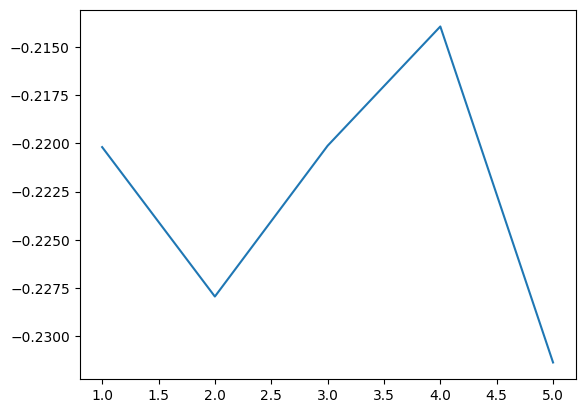

In [ ]:
# 시각화
import matplotlib.pyplot as plt
plt.plot(range(1,6), scores)
plt.show()

In [ ]:
# 파이프라인을 이용해서 전처리 포함 검증
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', RandomForestRegressor(max_depth = 5))
])
X = fetch_california_housing().data
y = fetch_california_housing().target
scores = cross_val_score(pipeline,X,y,cv=5,scoring='r2')
scores.mean()

np.float64(0.5452523197376061)

pipleline에서 파라메터 전달하는 방법

In [ ]:
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('lgb', LGBMRegressor())
])
pipe.set_params(lgb__boosting_type='dart')
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.7587172438571177

앙상블
```
  bagging : 같은 알고리즘을 서로 다른 데이터 샘플로 학습
  boosting : 약한 모델을 순차적으로 연견해서 학습
  stacking : 서로다른 알고리즘의 예측을 메타모델이 결합
```

In [ ]:
# voting
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
en = VotingRegressor(estimators = [('xgb',XGBRegressor()),
    ('rfr', RandomForestRegressor(n_estimators=100))]
)
pip = Pipeline([
    ('scaler', RobustScaler()),
    ('model',en)
])
pip.fit(X_train,y_train)
pip.score(X_test,y_test)
predict = pip.predict(X_test)
r2_score(y_test, predict)

0.831160842142152

In [ ]:
# bagging
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
bagging = BaggingRegressor(
    estimator = DecisionTreeRegressor(),
    n_estimators=10,
    random_state=42
)
pip = Pipeline([
    ('scaler', RobustScaler()),
    ('model', bagging)
])
pip.fit(X_train, y_train)
predict = pip.predict(X_test)
r2_score(y_test, predict)

0.7840689509568786

In [ ]:
#boosting
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# 이중에서 모델 하나 선택해서 전처리포함하는 파이프라인 만들고 결과
boosting = GradientBoostingRegressor(
    loss = 'squared_error',
    learning_rate= 0.01,
    n_estimators=200
)
pip = Pipeline([
    ('scaler', RobustScaler()),
    ('model', boosting)
])
pip.fit(X_train, y_train)
predict = pip.predict(X_test)
r2_score(y_test, predict)

0.618160116316071

In [ ]:
from sklearn.ensemble import StackingRegressor
# final_estimator 메타 모델
estimators = [
    ('lgb', LGBMRegressor()),
    ('xgb', XGBRegressor())
]
final_estimator = RandomForestRegressor()
stacking = StackingRegressor(estimators=estimators,final_estimator=final_estimator)
pip = Pipeline([
    ('scaler', RobustScaler()),
    ('model', stacking)
])
pip.fit(X_train,y_train)
predict = pip.predict(X_test)
r2_score(y_test,predict)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 8
[LightGBM] [Info] Start training from score 2.067432


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 8
[LightGBM] [Info] Start training from score 2.070997


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 8
[LightGBM] [Info] Start training from score 2.071631


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 8
[LightGBM] [Info] Start training from score 2.079625


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 8
[LightGBM] [Info] Start training from score 2.070050


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.8179909091083584

파이프라인 구성
```
전처리 --> 클래스로 구
  정규화, 결측치, 이상치, 피처엔지니어링
  상속클래스
    BaseEstimator
      파라메터를 설정 GridSearch, pipeline에서 호환성좋음
    TransformerMinMax
      fit, transform이 있음 데이터 적용 및 변환기능
앙상블 모델
```

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
class CustomPreprocess(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.scaler = RobustScaler()
    self.imputer = SimpleImputer(strategy='median')

  def fit(self, X, y=None):
      new_feature = self._create_feature(X)
      X_new = np.hstack([X, new_feature])
      X_new = self.imputer.fit_transform(X_new)
      self.scaler.fit(X_new)
      return self

  def transform(self, X):
      new_feature = self._create_feature(X)
      X_new = np.hstack([X, new_feature])
      X_new = self.imputer.transform(X_new)
      return self.scaler.transform(X_new)

  def _create_feature(self, X):
      epsilon = 1e-8  # to prevent division by zero
      return (X[:, 3] / (X[:, 2] + epsilon)).reshape(-1, 1)

X = fetch_california_housing().data
y = fetch_california_housing().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'model__max_depth' : [3,5,7],
    'model__learning_rate' : [0.05, 0.1, 0.5]
}
pip = Pipeline([
    ('preprocess', CustomPreprocess()),
    ('model', LGBMRegressor())
])
grid = GridSearchCV(pip,param_grid,cv=5, scoring='r2')
grid.fit(X_train,y_train)
predict = grid.predict(X_test)  # 자체적으로 best_estimator 동작

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 9
[LightGBM] [Info] Start training from score 2.067432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.071631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.070050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 9
[LightGBM] [Info] Start training from score 2.070997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 9
[LightGBM] [Info] Start training from score 2.070997


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.071631


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.079625


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.070050


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 9
[LightGBM] [Info] Start training from score 2.067432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.071631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.070050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.071631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.079625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 9
[LightGBM] [Info] Start training from score 2.070997


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.071631


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.079625


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.070050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 9
[LightGBM] [Info] Start training from score 2.067432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 9
[LightGBM] [Info] Start training from score 2.067432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 9
[LightGBM] [Info] Start training from score 2.070997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.071631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.079625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.070050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 9
[LightGBM] [Info] Start training from score 2.067432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.071631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 9
[LightGBM] [Info] Start training from score 2.079625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 9
[LightGBM] [Info] Start training from score 2.071947


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [31]:
r2_score(y_test,predict), print(grid.best_params_)

{'model__learning_rate': 0.1, 'model__max_depth': 7}


(0.8315031058733191, None)

In [32]:
import numpy as np
new_feature = (X[:,3]/X[:,2]).reshape(-1,1)
new_feature.shape, X.shape
X = np.hstack([X,new_feature])
print(X.shape)
np.delete(X,[2,3],axis = 1).shape

(20640, 9)


(20640, 7)